# Bias and variance of SVMs

*Fraida Fund*

In this notebook, we will explore the bias and variance of SVM models, and see how we can tune this tradeoff.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tqdm import tqdm

from sklearn.datasets import make_blobs

### Regularization level

Suppose we want to train a model to classify two “blobs” of data.

In [2]:
n_repeat = 100
n_test = 500
n_train = 100
sigma= 0.8
cluster_centers = np.array([[-1,1],[2,2]])

In [3]:
y_predict = np.zeros((n_test, n_repeat, 2))

In [4]:
x_test, y_test = make_blobs(n_samples=n_test, centers=cluster_centers,
                  random_state=0, cluster_std=sigma)

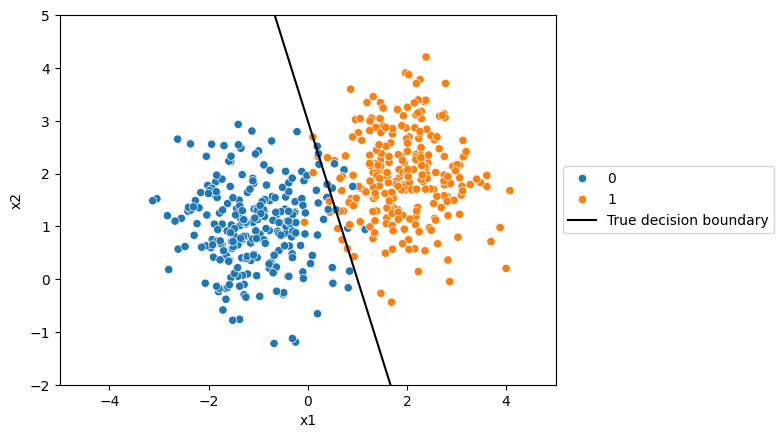

In [5]:
sns.scatterplot(x=x_test[:,0], y=x_test[:,1], hue=y_test);

plt.xlabel("x1");
plt.ylabel("x2");
plt.xlim(-5,5);
plt.ylim(-2,5);

# get the true decision boundary
mid = [cluster_centers[:,0].mean(), cluster_centers[:,1].mean()]
slp = -1.0/((cluster_centers[1,1]-cluster_centers[0,1])/(cluster_centers[1,0]-cluster_centers[0,0]))
b = mid[1]-slp*mid[0]
x_true = np.arange(-5,5)
y_true = slp*x_true + b
sns.lineplot(x=x_true, y=y_true, color='black', label="True decision boundary")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1);

Which will have greater bias, and which will have greater variance?

-   **Model A**: Linear SVM with $C=0.01$

-   **Model B**: Linear SVM with $C=100$

Note: here is $C$ in the SVM problem:

$$
\begin{aligned}
\operatorname*{minimize}_{\mathbf{w}, \mathbf{\epsilon}} \quad & \frac{1}{2} \sum_{j=1}^p w_j^2  + C \sum_{i=1}^n \epsilon_i  \\
\text{subject to} \quad & y_i(w_0 + \sum_{j=1}^p w_j x_{ij}) \geq 1-\epsilon_i, \quad \forall i \\
& \epsilon_i \geq 0, \quad \forall i
\end{aligned}
$$

The greater the value of $C$, the more heavily the “margin violators” penalize the overall objective function. Therefore,

-   If $C$ is large, the margin must be narrow (with few “margin violators”).
-   If $C$ is small, the margin may be wider (with more “margin violators”).

Simulation iteration: 100%|██████████| 100/100 [00:08<00:00, 11.57it/s]


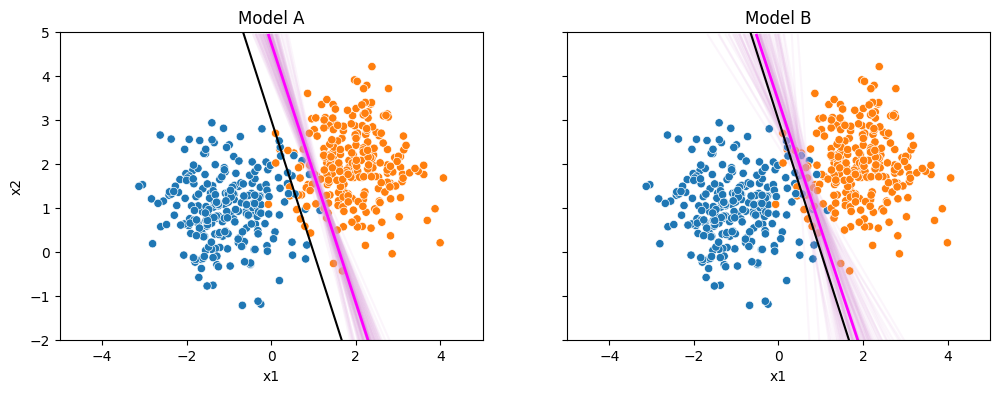

In [6]:
Z_sim = np.zeros((40000, n_repeat, 2))

fig = plt.figure(figsize=(12,4))
ax_a, ax_b = fig.subplots(1, 2, sharex=True, sharey=True)

# now simulate training the model many times, on different training data every time
# and evaluate using the test data
for i in tqdm(range(n_repeat), total=n_repeat, desc="Simulation iteration"):

  # train both models on newly generated training data
  X, y = make_blobs(n_samples=n_test, centers=cluster_centers,
                  cluster_std=sigma)

  clf_a = SVC(kernel='linear', C=0.01).fit(X, y)
  clf_b = SVC(kernel='linear', C=100.0).fit(X, y)

  y_predict[:, i, 0] = clf_a.predict(x_test)
  y_predict[:, i, 1] = clf_b.predict(x_test)


  xx, yy = np.meshgrid(np.arange(-5, 5, .05),
                      np.arange(-5, 5, .05))

  Z = clf_a.decision_function(np.c_[xx.ravel(), yy.ravel()])
  Z_sim[:, i, 0] = Z
  Z = Z.reshape(xx.shape)
  ax_a.contour(xx, yy, Z, levels=[0.5], alpha=0.1, colors='plum');

  plt.xlim(-5,5);
  plt.ylim(-2,5);

  Z = clf_b.decision_function(np.c_[xx.ravel(), yy.ravel()])
  Z_sim[:, i, 1] = Z
  Z = Z.reshape(xx.shape)
  ax_b.contour(xx, yy, Z, levels=[0.5], alpha=0.1, colors='plum');

  plt.xlim(-5,5);
  plt.ylim(-2,5);


cs_a = ax_a.contour(xx, yy, Z_sim[:,:,0].mean(axis=1).reshape(200,200), levels=[0.5], colors='magenta', linewidths=2);
cs_b = ax_b.contour(xx, yy, Z_sim[:,:,1].mean(axis=1).reshape(200,200), levels=[0.5], colors='magenta', linewidths=2);

# plot data
sns.scatterplot(x=x_test[:,0], y=x_test[:,1], hue=y_test, ax=ax_a, legend=False);
sns.scatterplot(x=x_test[:,0], y=x_test[:,1], hue=y_test, ax=ax_b, legend=False);

sns.lineplot(x=x_true, y=y_true, color='black', ax=ax_a)
sns.lineplot(x=x_true, y=y_true, color='black', ax=ax_b)


ax_a.set_title("Model A");
ax_b.set_title("Model B");

ax_a.set_ylabel("x2");
ax_a.set_xlabel("x1");
ax_b.set_xlabel("x1");

### Kernels

In [7]:
def generate_polynomial_classifier_data(n=100, xrange=[-1,1], coefs=[1,0.5,0,2], sigma=0.5):
  x = np.random.uniform(xrange[0], xrange[1], size=(n, 2))
  ysep = np.polynomial.polynomial.polyval(x[:,0],coefs)
  y = (x[:,1]>ysep).astype(int)
  x[:,0] = x[:,0] + sigma * np.random.randn(n)
  x[:,1] = x[:,1] + sigma * np.random.randn(n)
  return x, y

In [8]:
n_repeat = 100
n_test = 500
n_train = 1000
sigma= 0.3
coefs=np.array([0.3, 1, -1.5, -2])
xrange=[-1,1]

In [9]:
y_predict = np.zeros((n_test, n_repeat, 2))

In [10]:
# generate test data once
x_test, y_test = generate_polynomial_classifier_data(n=n_test, xrange=xrange, coefs=coefs, sigma=sigma)

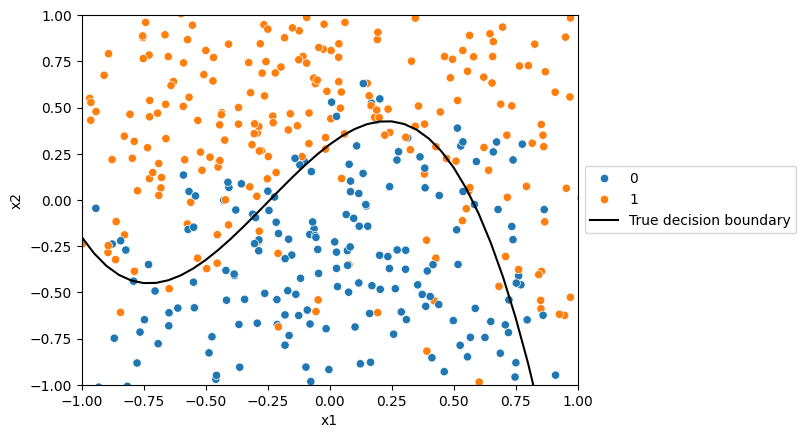

In [11]:
sns.scatterplot(x=x_test[:,0], y=x_test[:,1], hue=y_test);

plt.xlabel("x1");
plt.ylabel("x2");
plt.xlim((xrange[0], xrange[1]));
plt.ylim((xrange[0], xrange[1]));

# Plot true function
xtrue = np.arange(-1.5, 1.5, .05)
ytrue = np.polynomial.polynomial.polyval(xtrue,coefs)
sns.lineplot(x=xtrue, y=ytrue, color='black', label='True decision boundary');


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1);

Suppose we want to train a model to classify data that is separated by a polynomial boundary.

Which will have greater bias, and which will have greater variance?

-   **Model A**: SVM with linear kernel, $C = 1$

-   **Model B**: SVM with RBF kernel, $C = 1$

Simulation iteration: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


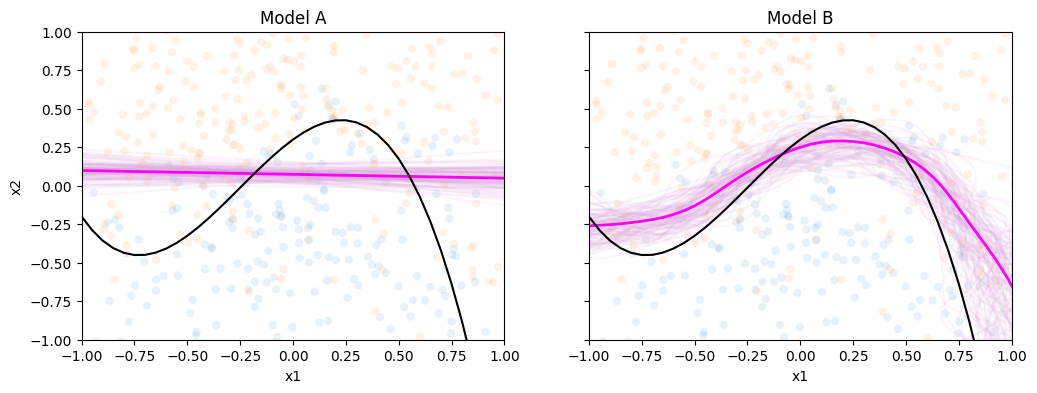

In [12]:
Z_sim = np.zeros((3600, n_repeat, 2))

fig = plt.figure(figsize=(12,4))
ax_a, ax_b = fig.subplots(1, 2, sharex=True, sharey=True)

# now simulate training the model many times, on different training data every time
# and evaluate using the test data
for i in tqdm(range(n_repeat), total=n_repeat, desc="Simulation iteration"):

  # train both models on newly generated training data
  X, y = generate_polynomial_classifier_data(n=n_train, xrange=xrange, coefs=coefs, sigma=sigma)

  clf_a = SVC(kernel='linear', C=1).fit(X, y)
  clf_b = SVC(kernel='rbf', gamma=10,  C=1).fit(X, y)

  y_predict[:, i, 0] = clf_a.predict(x_test)
  y_predict[:, i, 1] = clf_b.predict(x_test)


  xx, yy = np.meshgrid(np.arange(-1.5, 1.5, .05),
                      np.arange(-1.5, 1.5, .05))

  Z = clf_a.decision_function(np.c_[xx.ravel(), yy.ravel()])
  Z_sim[:, i, 0] = Z
  Z = Z.reshape(xx.shape)
  ax_a.contour(xx, yy, Z, levels=[0.5], alpha=0.1, colors='plum');
  plt.xlim((xrange[0], xrange[1]));
  plt.ylim((xrange[0], xrange[1]));

  Z = clf_b.decision_function(np.c_[xx.ravel(), yy.ravel()])
  Z_sim[:, i, 1] = Z
  Z = Z.reshape(xx.shape)
  ax_b.contour(xx, yy, Z, levels=[0.5], alpha=0.1, colors='plum');
  plt.xlim((xrange[0], xrange[1]));
  plt.ylim((xrange[0], xrange[1]));


cs_a = ax_a.contour(xx, yy, Z_sim[:,:,0].mean(axis=1).reshape(60,60), levels=[0.5], colors='magenta', linewidths=2);
cs_b = ax_b.contour(xx, yy, Z_sim[:,:,1].mean(axis=1).reshape(60,60), levels=[0.5], colors='magenta', linewidths=2);


# Plot true function
xtrue = np.arange(-1.5, 1.5, .05)
ytrue = np.polynomial.polynomial.polyval(xtrue,coefs)
sns.lineplot(x=xtrue, y=ytrue, color='black', ax=ax_a);
sns.lineplot(x=xtrue, y=ytrue, color='black', ax=ax_b);

sns.scatterplot(x=x_test[:,0], y=x_test[:,1], hue=y_test, ax=ax_a, legend=False, alpha=0.1);
sns.scatterplot(x=x_test[:,0], y=x_test[:,1], hue=y_test, ax=ax_b, legend=False, alpha=0.1);

ax_a.set_title("Model A");
ax_b.set_title("Model B");

ax_a.set_ylabel("x2");
ax_a.set_xlabel("x1");
ax_b.set_xlabel("x1");

### RBF parameter

Recall that the RBF kernel is defined as

$$K(x,z) = \exp(-\frac{\|x-z\|^2_2}{\sigma^2})$$

where $\sigma$ is the bandwidth, or equivalently, using a $\gamma$ parameter,

$$K(x, z) = \exp(-\gamma \| x - z \|^2_2 )$$

For example, here is the RBF kernel centered on a single point, computed over the entire feature space, with two different values of $\gamma$:

In [13]:
from sklearn.metrics.pairwise import rbf_kernel

test_point = np.random.uniform(0,1,size=2)
xx, yy = np.meshgrid(np.arange(0 ,5, .05), np.arange(0, 5, .05))

gamma_a=0.05
gamma_b=5
Z_a = rbf_kernel(np.c_[xx.ravel(), yy.ravel()], test_point.reshape(1, -1), gamma=gamma_a)
Z_b = rbf_kernel(np.c_[xx.ravel(), yy.ravel()], test_point.reshape(1, -1), gamma=gamma_b)

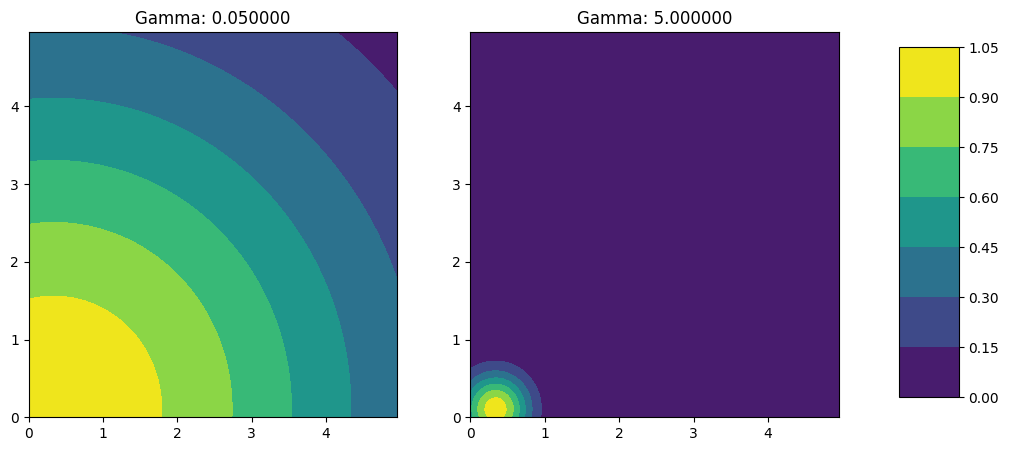

In [14]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)

plt.scatter(x=test_point[0], y=test_point[1])
cs = plt.contourf(xx, yy, Z_a.reshape(xx.shape), vmin=0, vmax=1);
plt.title("Gamma: %f" % gamma_a);

plt.subplot(1,2,2)


plt.scatter(x=test_point[0], y=test_point[1])
cs = plt.contourf(xx, yy, Z_b.reshape(xx.shape), vmin=0, vmax=1);
plt.title("Gamma: %f" % gamma_b);

plt.subplots_adjust(right=0.8);
cbar_ax = plt.axes([0.85, 0.15, 0.05, 0.7]);
plt.colorbar(cax=cbar_ax);

We can see that when the kernel bandwidth is large ($\gamma$ is small), the influence of each point extends much farther in the feature space than if the kernel bandwidth is small ($\gamma$ is large).

Suppose we want to train a model to classify data that is separated by a polynomial boundary.

Which will have greater bias, and which will have greater variance?

-   **Model A**: SVM with RBF kernel and $\gamma=0.05$

-   **Model B**: SVM with RBF kernel and $\gamma=5$

In [15]:
n_repeat = 100
n_test = 500
n_train = 100
sigma= 0.3
coefs=np.array([0.3, 1, -1.5, -2])
xrange=[-1,1]

In [16]:
y_predict = np.zeros((n_test, n_repeat, 2))

In [17]:
# generate test data once
x_test, y_test = generate_polynomial_classifier_data(n=n_test, xrange=xrange, coefs=coefs, sigma=sigma)

Simulation iteration: 100%|██████████| 100/100 [00:03<00:00, 28.71it/s]


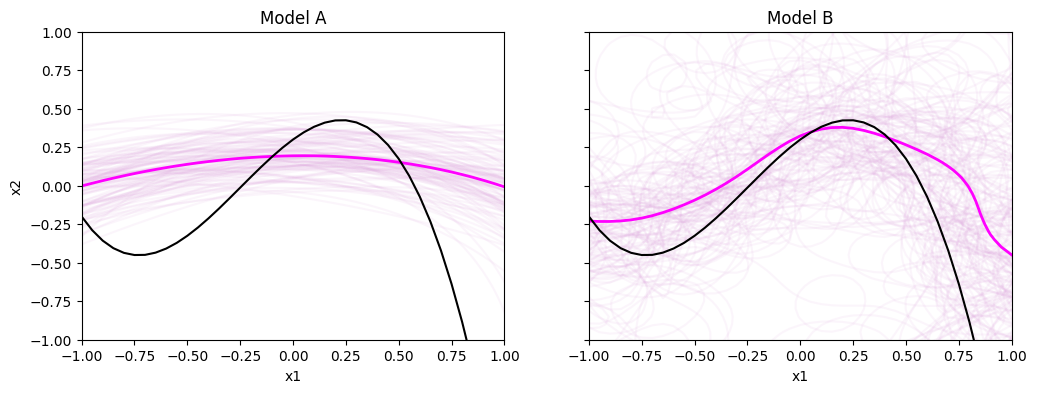

In [18]:
Z_sim = np.zeros((3600, n_repeat, 2))

fig = plt.figure(figsize=(12,4))
ax_a, ax_b = fig.subplots(1, 2, sharex=True, sharey=True)

# now simulate training the model many times, on different training data every time
# and evaluate using the test data
for i in tqdm(range(n_repeat), total=n_repeat, desc="Simulation iteration"):

  # train both models on newly generated training data
  X, y = generate_polynomial_classifier_data(n=n_train, xrange=xrange, coefs=coefs, sigma=sigma)

  clf_a = SVC(kernel='rbf', gamma=0.05, C=10).fit(X, y)
  clf_b = SVC(kernel='rbf', gamma=5, C=10).fit(X, y)

  y_predict[:, i, 0] = clf_a.predict(x_test)
  y_predict[:, i, 1] = clf_b.predict(x_test)


  xx, yy = np.meshgrid(np.arange(-1.5, 1.5, .05),
                      np.arange(-1.5, 1.5, .05))

  Z = clf_a.decision_function(np.c_[xx.ravel(), yy.ravel()])
  Z_sim[:, i, 0] = Z
  Z = Z.reshape(xx.shape)
  ax_a.contour(xx, yy, Z, levels=[0.5], alpha=0.1, colors='plum');
  plt.xlim((xrange[0], xrange[1]));
  plt.ylim((xrange[0], xrange[1]));

  Z = clf_b.decision_function(np.c_[xx.ravel(), yy.ravel()])
  Z_sim[:, i, 1] = Z
  Z = Z.reshape(xx.shape)
  ax_b.contour(xx, yy, Z, levels=[0.5], alpha=0.1, colors='plum');
  plt.xlim((xrange[0], xrange[1]));
  plt.ylim((xrange[0], xrange[1]));


cs_a = ax_a.contour(xx, yy, Z_sim[:,:,0].mean(axis=1).reshape(60,60), levels=[0.5], colors='magenta', linewidths=2);
cs_b = ax_b.contour(xx, yy, Z_sim[:,:,1].mean(axis=1).reshape(60,60), levels=[0.5], colors='magenta', linewidths=2);


# Plot true function
xtrue = np.arange(-1.5, 1.5, .05)
ytrue = np.polynomial.polynomial.polyval(xtrue,coefs)
sns.lineplot(x=xtrue, y=ytrue, color='black', ax=ax_a);
sns.lineplot(x=xtrue, y=ytrue, color='black', ax=ax_b);

#sns.scatterplot(x_test[:,0], x_test[:,1], y_test, ax=ax_a, legend=False, alpha=0.1);
#sns.scatterplot(x_test[:,0], x_test[:,1], y_test, ax=ax_b, legend=False, alpha=0.1);

ax_a.set_title("Model A");
ax_b.set_title("Model B");

ax_a.set_ylabel("x2");
ax_a.set_xlabel("x1");
ax_b.set_xlabel("x1");